In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import alexnet
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [29]:
# Vérification de l'utilisation du gpu
!nvidia-smi 

# Optimisation Pytorch
torch.backends.cudnn.benchmark = True  # Accélère les convolutions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Utilisation de :", device)

Sat Nov 15 11:36:47 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8              12W /  95W |   2993MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Implementation de AlexNet

Imporation des libraries

Creation de l'architecture ##########################

-Feature Extractor: La première couche de convolution prend une image à 3 canaux et passe un kernel de taille 11x11 avec un pas de 4 réduit. Les fonction d'activation sont des ReLu (conserve les y positives et renvoi 0 pour les y négatifs) Ensuite, un maxpooling est appliqué pour réduire la dimension des images et concerver les informations importantes

-Classifier: Ensemble de percptron multi-couches avec des fonction d'activation ReLu Les features (les x) sont projetées dans un espace de grande dimension ici de taille 4096. La dernière couches est la sortie du reseau

-Forward: Calcul du lien entre les entrées et les sorties (f(x)) ou on défini le passage des entrées dans le Feature extractor, les features sont transformées en vecteur (fletten) puis les vecteurs de features sont passées dans les PMC.

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000): #num_classes a modifier en fonction du nombre de sorties souhaité
        super(AlexNet, self).__init__()

        # Feature Extractor = couches de convolution et pooling
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool1
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool3
        )

        # Classifier = couches de PMC
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  #Couche de sortie
        )

    #Calcul des f(x)
    def forward(self, x):
        x = self.features(x)  # Calcul a traver les couches de convolution
        x = torch.flatten(x, 1)  # Les sorties de la convolution sont transformées en vecteurs pour être utilisable par les PMC
        x = self.classifier(x)  # Calcul a traver les couches de PMC
        return x

Traitement des données ######################

-Transformation des données: Ici la taille des images est modifiée, les images sont converties en tenseurs et enfin normalisées. En effet, AlexNet doit traiter des images en 227x227 pixels. Le normalisation permet une convergence plus rapide.

-Chargement des données

-Création d'un dataloader

In [16]:
# === 1. Chargement des images en Tensor (sans normalisation)
root = r"DATA/data_test_bug_ant_bee"

temp_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root=root, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# === 2. Calcul des moyennes et écarts-types
mean = 0.0
std = 0.0
total_images = 0

for images, _ in temp_loader:
    batch_samples = images.size(0)  # nombre d'images dans le batch
    images = images.view(batch_samples, images.size(1), -1)  # (batch, 3, H*W)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("✅ Mean :", mean)
print("✅ Std  :", std)

# === 3. Transformation finale avec tes valeurs calculées
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# === 4. Chargement du dataset complet avec normalisation adaptée
dataset = datasets.ImageFolder(root=root, transform=transform)

# === 5. Division en train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# === 6. DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True,
    num_workers=0, pin_memory=True, persistent_workers=False
)
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False,
    num_workers=0, pin_memory=True, persistent_workers=False
)

print(f"Nombre d'images total : {len(dataset)}")
print(f"Train : {len(train_dataset)}, Test : {test_size}")
print(f"Classes : {dataset.classes}")

✅ Mean : tensor([0.4425, 0.5082, 0.2139])
✅ Std  : tensor([0.1524, 0.1685, 0.0976])
Nombre d'images total : 2132
Train : 1705, Test : 427
Classes : ['ant', 'bee']


Entrainement du modèle
######################

-Définition du modèle:
On défini notre modèle comme étant l'architecture générée en partie "Creation de l'architecture".

-Fonction loss:
Définition de la fonction loss qui est ici une crossentropy.

-Optimizeer:
Définition de la descente de gradient

In [22]:
# Définition du modèle
model = AlexNet(num_classes=len(dataset.classes)).to('cuda')  #  pour calculer sur GPU

# Fonction loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Scheduler (permet d'optimiser le learning, ici on veut le mettre a jour toutes les 5 epoches)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Boucle d'entrainnement ######################

In [23]:
!nvidia-smi

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # barre de progression pour chaque epoch
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        try:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        except Exception as e:
            print(f"Error loading data for epoch {epoch+1}: {e}")
            continue

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()

    scheduler.step()  # on met à jour le learning rate après l’epoch

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Sat Nov 15 11:06:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              13W /  95W |   1524MiB /  6144MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Epoch [1/10] - Loss: 0.6918


Epoch [2/10] - Loss: 0.6821


Epoch [3/10] - Loss: 0.6453


Epoch [4/10] - Loss: 0.5536


Epoch [5/10] - Loss: 0.4880


Epoch [6/10] - Loss: 0.4621


Epoch [7/10] - Loss: 0.4352


Epoch [8/10] - Loss: 0.4201


Epoch [9/10] - Loss: 0.4055


Epoch [10/10] - Loss: 0.3931


Validation ##########

Permet de tester la capacité du modèle à généraliser. Ici on ne fait pas l'étape backward car on ne veut pas mettre a jour les poids, mais on réalise uniquement l'étape forward pour réaliser les prédictions

In [24]:
model.eval()  # On déclare qu'on est en validation
total, correct = 0, 0  # Suivi des images bien classées

with torch.no_grad():  # Désactivation du calcul du gradient
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Passage des données vers un GPU
        outputs = model(images)  # Forward
        _, predicted = outputs.max(1)  # Donne la prédiction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 88.76%


Fine-Tuning et transfert d'apprentissage ######################

En remplaçant la dernière couche entièrement connectée (model.classifier[6]), on indique à AlexNet d'ajuster ses prédictions à votre ensemble de données personnalisé. Les couches antérieures restent intactes, conservant les caractéristiques apprises, tandis que la nouvelle couche apprend à classer vos catégories spécifiques.

In [ ]:
from torch import nn
from torchvision.models import alexnet

# Importation du pre-trained AlexNet
model = alexnet(pretrained=True).to('cuda') # Move the model to GPU

# modif de la dernière couche pour avoir que 3 classes + alexnet sur gpu
model.classifier[6] = nn.Linear(4096, len(dataset.classes)).to('cuda')

for param in model.features.parameters():
    param.requires_grad = False

# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# criterion sur GPU
criterion = criterion.to('cuda')

# Boucle train
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\matso/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


Epoch [1/5], Loss: 0.3695
Epoch [2/5], Loss: 0.1046
Epoch [3/5], Loss: 0.0840
Epoch [4/5], Loss: 0.0807
Epoch [5/5], Loss: 0.0734


Epoch [1/10], Loss: 0.0751, Accuracy: 97.48%
Epoch [2/10], Loss: 0.0638, Accuracy: 97.65%
Epoch [3/10], Loss: 0.0563, Accuracy: 98.18%
Epoch [4/10], Loss: 0.0517, Accuracy: 97.95%
Epoch [5/10], Loss: 0.0492, Accuracy: 98.24%
Epoch [6/10], Loss: 0.0439, Accuracy: 98.18%
Epoch [7/10], Loss: 0.0524, Accuracy: 98.18%
Epoch [8/10], Loss: 0.0382, Accuracy: 98.59%
Epoch [9/10], Loss: 0.0387, Accuracy: 98.65%
Epoch [10/10], Loss: 0.0459, Accuracy: 98.53%


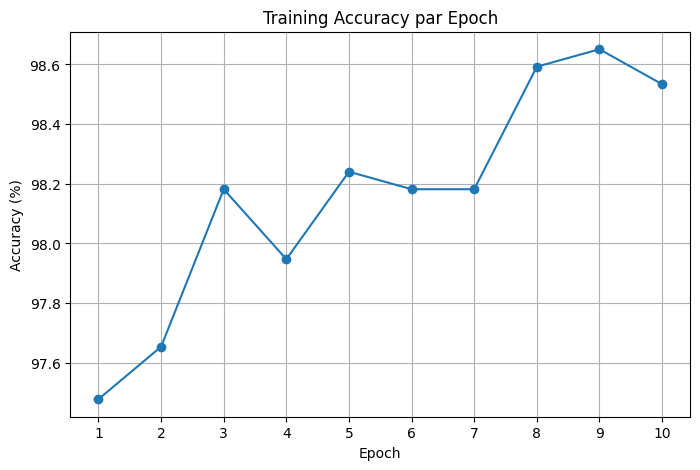

In [ ]:
import matplotlib.pyplot as plt
import torch

num_epochs = 10
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcul des bonnes prédictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Accuracy de l'epoch
    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}%")

# --- Plot de l'accuracy ---
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o')
plt.title("Training Accuracy par Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, num_epochs+1))
plt.grid(True)
plt.show()


In [28]:
model.eval()  # On déclare qu'on est en validation
total, correct = 0, 0  # Suivi des images bien classées

with torch.no_grad():  # Désactivation du calcul du gradient
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Passage des données vers un GPU
        outputs = model(images)  # Forward
        _, predicted = outputs.max(1)  # Donne la prédiction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 98.59%


In [32]:
import zipfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ZipDataset(Dataset):
    def __init__(self, zip_path, transform=None):
        self.zip_path = zip_path
        self.transform = transform
        self.zip_file = zipfile.ZipFile(zip_path, 'r')
        # Liste des fichiers images dans le ZIP
        self.img_files = [f for f in self.zip_file.namelist() if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Lire l'image directement depuis le ZIP
        img_name = self.img_files[idx]
        with self.zip_file.open(img_name) as f:
            img = Image.open(f).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# --- Exemple d'utilisation ---
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

dataset = ZipDataset("DATA/5_img.zip", transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Tester
for imgs in loader:
    print(imgs.shape)  # torch.Size([batch_size, 3, 227, 227])
    break

torch.Size([4, 3, 227, 227])
